In [1]:
import random
import pickle
import numpy as np
import pandas as pd
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
print(1)

1


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
with open("./data/en_US.blogs.txt", "r", encoding = "utf8") as f:
    data = f.read()

In [5]:
def tokenize(data):
    sentences = data.split("\n")
    joined_text = " ".join([sentence.strip().lower() for sentence in sentences])
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(joined_text.lower())
    return tokens

In [22]:
sentences = data.split("\n")
joined_text = " ".join([sentence.strip().lower() for sentence in sentences])
partial_text = joined_text[:1000]
tokenizer = Tokenizer()
tokenizer.fit_on_texts([partial_text])
sequence_data = tokenizer.texts_to_sequences([partial_text])[0]

In [23]:
len(sequence_data)

199

In [25]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

129


In [26]:
#unique_tokens = np.unique(tokens)
#unique_tokens_index = {token: idx for idx, token in enumerate(unique_tokens)}

In [8]:
n_words = 6
input_words = []
next_words = []

In [9]:
for i in range(len(tokens) - n_words):
    input_words.append(tokens[i: i+n_words])
    next_words.append(tokens[i+n_words])

In [25]:
input_words[:10]


[['the', 'project', 'gutenberg', 'ebook', 'of', 'the'],
 ['project', 'gutenberg', 'ebook', 'of', 'the', 'blue'],
 ['gutenberg', 'ebook', 'of', 'the', 'blue', 'castle'],
 ['ebook', 'of', 'the', 'blue', 'castle', 'by'],
 ['of', 'the', 'blue', 'castle', 'by', 'lucy'],
 ['the', 'blue', 'castle', 'by', 'lucy', 'maud'],
 ['blue', 'castle', 'by', 'lucy', 'maud', 'montgomery'],
 ['castle', 'by', 'lucy', 'maud', 'montgomery', 'this'],
 ['by', 'lucy', 'maud', 'montgomery', 'this', 'ebook'],
 ['lucy', 'maud', 'montgomery', 'this', 'ebook', 'is']]

In [26]:
next_words[:10]

['blue',
 'castle',
 'by',
 'lucy',
 'maud',
 'montgomery',
 'this',
 'ebook',
 'is',
 'for']

In [10]:
len(unique_tokens)

7386

In [11]:
X = np.zeros((len(input_words), n_words, len(unique_tokens)), dtype=bool) # n_words bag of words with one position set to 1 (ten times of this)
Y = np.zeros((len(next_words), len(unique_tokens)), dtype=bool) # only one set to 1

In [12]:
for i, words in enumerate(input_words):
    for j,word in enumerate(words):
        X[i,j, unique_tokens_index[word]] = 1
    Y[i, unique_tokens_index[next_words[i]]] = 1

In [13]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X,Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp,Y_temp, test_size=0.5, random_state=42)

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape = (n_words, len(unique_tokens)), return_sequences=True))
model.add(Dropout(0.2))  # Add dropout with a rate of 0.2
model.add(LSTM(128))
model.add(Dropout(0.2))  # Add dropout with a rate of 0.2
model.add(Dense(len(unique_tokens)))
model.add(Activation("softmax"))
#model = load_model("mymodel.h5")

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 128)            3847680   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 7386)              952794    
                                                                 
 activation (Activation)     (None, 7386)              0         
                                                                 
Total params: 4,932,058
Trainable params: 4,932,058
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss="categorical_crossentropy", optimizer=RMSprop(learning_rate=0.01), metrics=["accuracy"])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(X_train,Y_train, batch_size=32, epochs=50, shuffle=True, validation_data=(X_val, Y_val))

Epoch 1/50
1868/1868 [==============================] - 32s 14ms/step - loss: 7.7091 - accuracy: 0.0305 - val_loss: 8.2435 - val_accuracy: 0.0352
Epoch 2/50
1868/1868 [==============================] - 25s 13ms/step - loss: 7.9367 - accuracy: 0.0701 - val_loss: 8.2137 - val_accuracy: 0.0829
Epoch 3/50
1868/1868 [==============================] - 25s 13ms/step - loss: 7.8970 - accuracy: 0.0855 - val_loss: 8.5146 - val_accuracy: 0.0838
Epoch 4/50
1868/1868 [==============================] - 23s 12ms/step - loss: 7.6854 - accuracy: 0.1035 - val_loss: 8.5890 - val_accuracy: 0.0796
Epoch 5/50
1868/1868 [==============================] - 17s 9ms/step - loss: 7.3521 - accuracy: 0.1275 - val_loss: 8.8615 - val_accuracy: 0.0897
Epoch 6/50
1868/1868 [==============================] - 17s 9ms/step - loss: 6.9422 - accuracy: 0.1552 - val_loss: 9.6086 - val_accuracy: 0.0962
Epoch 7/50
1868/1868 [==============================] - 17s 9ms/step - loss: 6.5698 - accuracy: 0.1862 - val_loss: 10.0982 - v

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


234/234 [==============================] - 1s 5ms/step - loss: 23.6468 - accuracy: 0.0597
Test Loss: 23.646760940551758, Test Accuracy: 0.05968950688838959


In [18]:
model.save("myModel.h5")

In [19]:
model = load_model("mymodel.h5")

In [20]:
def predict_next_word(input_text, n_best):
    input_text = input_text.lower()
    X = np.zeros((1,n_words,len(unique_tokens)))
    num_of_words = 0
    input_words = input_text.split()
    for i in range(len(input_words)-1, -1, -1):
        if num_of_words >= n_words:
            break
        if input_words[i] in unique_tokens_index.keys():
            X[0,n_words - num_of_words - 1,unique_tokens_index[input_words[i]]] = 1
            print(f"{input_words[i]}:{n_words - num_of_words - 1}")
            num_of_words += 1
        
    predictions = model.predict(X)[0]
    top_n_idx = np.argsort(predictions)[-n_best:][::-1]
    predicted_words = [list(unique_tokens_index.keys())[idx] for idx in top_n_idx]
    return predicted_words

In [21]:
possible = predict_next_word("This ensures that the model works with the",5)

the:5
with:4
works:3
the:2
that:1
this:0
1/1 [==============================] - 0s 427ms/step


In [22]:
print(possible)

['come', 's', 'mother', 'been', 'first']


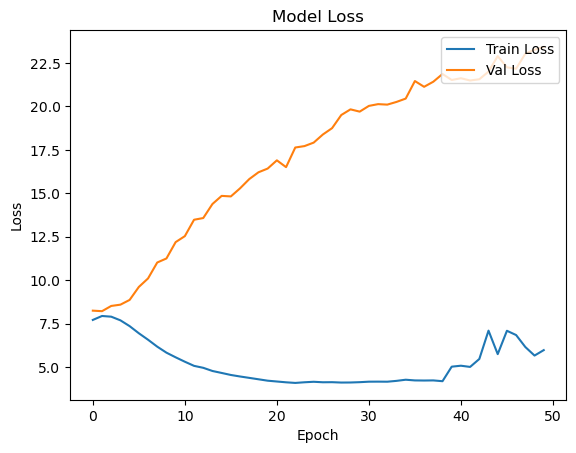

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


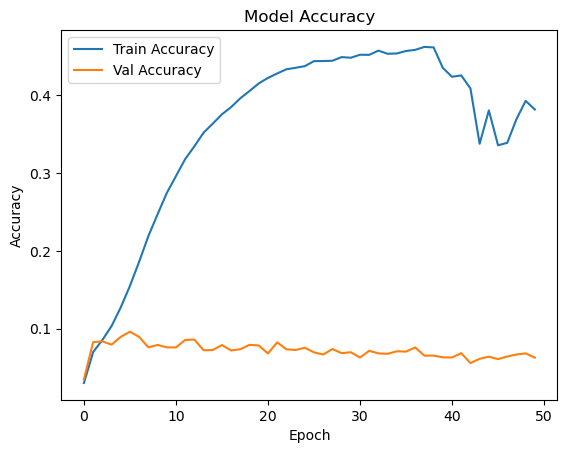

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
